# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [26]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [27]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [28]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [29]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [30]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [31]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [32]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [33]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [34]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [35]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [36]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [37]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [38]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [39]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [40]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [41]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [42]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this stuff.  I nuke a mug a milk until it is very hot, drop in 2 of the triangles, stir until the chocolate melts, then froth it with my Aerolatte.  Simple and tasty.


In [43]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [44]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this stuff I nuke a mug a milk until it is very hot drop in 2 of the triangles stir until the chocolate melts then froth it with my Aerolatte Simple and tasty 


In [45]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [46]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 126357/126357 [00:56<00:00, 2252.95it/s]


In [47]:
preprocessed_reviews[1500]

'love stuff nuke mug milk hot drop triangles stir chocolate melts froth aerolatte simple tasty'

In [48]:
#replacing the reviews with preprocessed reviews 
final['Text']=preprocessed_reviews 


# positive = final[final["Score"] == 1].sample(n = 50000)
# negative = final[final["Score"] == 0].sample(n = 50000)
# final_posinegi = pd.concat([positive, negative])
# final_posinegi.shape

In [50]:
final = final.sample(n = 100000)

In [61]:
fd = final
# Sorting based on time
fd['Time'] = pd.to_datetime(fd['Time'], origin='unix', unit='s')
fd= fd.sort_values('Time')
fd.shape

(100000, 10)

In [62]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

print("After Standardization")
scalar = StandardScaler(with_mean=False)
X_train_scale=scalar.fit_transform(X_train_bow)
X_test_scale=scalar.transform(X_test_bow)
print(X_train_scale.shape, y_train.shape) 
print(X_test_scale.shape, y_test.shape)

After vectorizations
(67000, 39329) (67000,)
(33000, 39329) (33000,)
After Standardization
(67000, 39329) (67000,)
(33000, 39329) (33000,)


### For RBF kernel taking 20K datapoints and max features = 500

In [66]:
# positive_1 = final[final["Score"] == 1].sample(n = 20000)
# negative_1 = final[final["Score"] == 0].sample(n = 20000)
# final_posinegi_1 = pd.concat([positive_1, negative_1])
fd_1 = final.sample(n=20000)
# Sorting based on time
fd_1['Time'] = pd.to_datetime(fd_1['Time'], origin='unix', unit='s')
fd_1= fd_1.sort_values('Time')
fd_1.shape

(20000, 10)

In [67]:
#splitting data into X and Y
Y_1= fd_1.Score
X_1=fd_1.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train_1.shape, y_train_1.shape)
print('Test---->',X_test_1.shape, y_test_1.shape)

Before Vectorization
Train---> (13400,) (13400,)
Test----> (6600,) (6600,)


In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(ngram_range=(1,2), min_df=10 , max_features=500)
vectorizer1.fit(X_train_1) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_rbf = vectorizer1.transform(X_train_1)
X_test_bow_rbf = vectorizer1.transform(X_test_1)

print("After vectorizations")
print(X_train_bow_rbf.shape, y_train_1.shape)
print(X_test_bow_rbf.shape, y_test_1.shape)

print("After Standardization")
scalar = StandardScaler(with_mean=False)
X_train_scale_rbf=scalar.fit_transform(X_train_bow_rbf)
X_test_scale_rbf=scalar.transform(X_test_bow_rbf)
print(X_train_scale_rbf.shape, y_train_1.shape) 
print(X_test_scale_rbf.shape, y_test_1.shape)

After vectorizations
(13400, 500) (13400,)
(6600, 500) (6600,)
After Standardization
(13400, 500) (13400,)
(6600, 500) (6600,)


## [4.2] Bi-Grams and n-Grams.

In [93]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (126357, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [94]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=10000)
tf_idf_vect.fit(X_train)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

print("After Standardization")
scalar = StandardScaler(with_mean=False)
X_train_tfidf=scalar.fit_transform(X_train_tfidf)
X_test_tfidf=scalar.transform(X_test_tfidf)
print(X_train_tfidf.shape, y_train.shape) 
print(X_test_tfidf.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)
After vectorizations
(67000, 10000) (67000,)
(33000, 10000) (33000,)
After Standardization
(67000, 10000) (67000,)
(33000, 10000) (33000,)


### for rbf kernel

In [95]:
#splitting data into X and Y
Y_1= fd_1.Score
X_1=fd_1.Text
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.33, shuffle=False)# this is for time series split
print('Before Vectorization')
print('Train--->',X_train_1.shape, y_train_1.shape)
print('Test---->',X_test_1.shape, y_test_1.shape)

tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=500)
tf_idf_vect1.fit(X_train_1)

X_train_tfidf_rbf = tf_idf_vect1.transform(X_train_1)
X_test_tfidf_rbf = tf_idf_vect1.transform(X_test_1)

print("After vectorizations")
print(X_train_tfidf_rbf.shape, y_train.shape)
print(X_test_tfidf_rbf.shape, y_test.shape)

print("After Standardization")
scalar = StandardScaler(with_mean=False)
X_train_tfidf_rbf=scalar.fit_transform(X_train_tfidf_rbf)
X_test_tfidf_rbf=scalar.transform(X_test_tfidf_rbf)
print(X_train_tfidf_rbf.shape, y_train.shape) 
print(X_test_tfidf_rbf.shape, y_test.shape)

Before Vectorization
Train---> (13400,) (13400,)
Test----> (6600,) (6600,)
After vectorizations
(13400, 500) (67000,)
(6600, 500) (33000,)
After Standardization
(13400, 500) (67000,)
(6600, 500) (33000,)


## [4.4] Word2Vec

In [96]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False) 
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### Converting train data

In [97]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
from tqdm import tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 67000/67000 [12:22<00:00, 90.19it/s] 


(67000, 50)
[-0.44501233  0.75709684 -0.20294965  0.27123779  0.29906023  0.28310461
 -0.05736588  0.31235301 -0.2204515  -0.51838443 -0.26575952 -0.08141635
  0.36588168  0.79848135  0.08124884  0.19035662 -0.13962943 -0.05863764
  0.26415204  0.05938924 -0.19272196 -0.44914088  0.07254118 -0.44266271
  0.22151562 -0.47127283  0.26717477 -0.20402768  0.35175456 -0.25075239
 -0.07932488 -0.28979613  0.41190617  0.0044423  -0.07794274 -0.0471486
 -0.07373792 -0.58517214 -0.19309772  0.42479098 -0.39449189 -0.36954636
  0.77413871 -0.57963124  0.1247682   0.15318847 -0.49845137 -0.40185224
  0.19353972  0.07029189]


#### converting test data

In [98]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 33000/33000 [06:44<00:00, 81.57it/s] 


(33000, 50)
[ 0.47962586  0.5887203  -0.85070463  0.05326523  0.58750504 -0.01019093
 -0.47386517 -0.37010149 -0.75136047  1.14954724  0.07154555  0.31086042
  0.08997923 -0.44740226  0.57445378  0.12324523 -0.27937024 -0.29379831
  0.11225289  0.20775415  0.27718283 -0.23533585 -0.23494728  0.65093798
  0.76528396  0.05524846  1.32222477 -0.33724299 -0.35611154 -0.2307401
  0.99000212  0.04422561  0.87051359 -0.7725481  -1.15344544 -0.46342555
  0.8547277  -0.20570222  0.21630662  0.398692    0.30139316  0.72300899
  0.41763279  1.16238855  0.55449766 -0.25509846  0.56723886  0.10198344
 -0.40168055  0.06477354]


In [99]:
print(sent_vectors_train.shape,sent_vectors_test.shape)

(67000, 50) (33000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [100]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
model1 = TfidfVectorizer()
tf_idf_train_w2v= model1.fit_transform(X_train)
tf_idf_test_w2v= model1.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model1.get_feature_names(), list(model1.idf_)))
print(tf_idf_train_w2v.shape, tf_idf_test_w2v.shape)

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)
(67000, 48378) (33000, 48378)


### Converting train data

In [101]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_train = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

100%|██████████| 67000/67000 [1:08:10<00:00, 16.38it/s]


### Converting test data

In [102]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_test = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

100%|██████████| 33000/33000 [23:21<00:00, 23.55it/s]  


In [103]:
print(tfidf_sent_vectors_train.shape,tfidf_sent_vectors_test.shape)

(67000, 50) (33000, 50)


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

# Function for finding the best C using gridsearch on SGD Regressor using hinge loss (linear SVM)

In [104]:
def linearsvc(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    import numpy as np
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    parameters = {'alpha': [10**x for x in range(-4,4)]}
    K =[10**x for x in range(-4,4)]
    K = np.log10(K)
    
    svm = SGDClassifier(class_weight='balanced')
    clf = GridSearchCV(svm, parameters, cv=5, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']
    bestparam = clf.best_params_
    best_c = list(bestparam.values())[0]


    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("alpha : hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return best_c

# Function for picking the best threshold that will give the least fpr

In [80]:
# we are writing our own function for predict, with defined thresholds
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    import numpy as np
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Function for confusion matrix for best threshold values

In [81]:
def conf_matrix(Xtrain,ytrain,Xtest,ytest,best_t,model):
    #https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
    import seaborn as sns
    %matplotlib inline
    sns.set()

    y_train_pred = model.predict_proba(Xtrain)[:,1] 
    y_test_pred = model.predict_proba(Xtest)[:,1]
    from sklearn.metrics import confusion_matrix
    print('Train Data')
    cm = confusion_matrix(ytrain, predict_with_best_t(y_train_pred, best_t))
    cl = ['Negative', 'Positive']
    confusion_df = pd.DataFrame(cm, index=cl, columns=cl)
    sns.heatmap(confusion_df, annot=True, cbar = False,fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()   
    print('='*50)
    print('Test Data')
    cm_test= (confusion_matrix(ytest, predict_with_best_t(y_test_pred, best_t)))
    confusion_df_test = pd.DataFrame(cm_test, index=cl, columns=cl)
    sns.heatmap(confusion_df_test, annot=True, fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

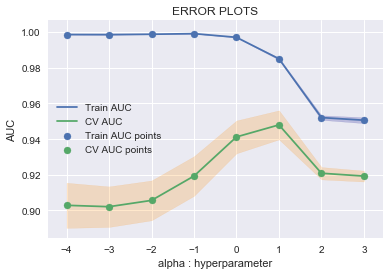

Best aplha is :  10
Wall time: 7.39 s


In [105]:
%%time
best_c_bow = linearsvc(X_train_scale,y_train)
print('Best aplha is : ', best_c_bow)

### Training Linear SVM model using best hyperparameter

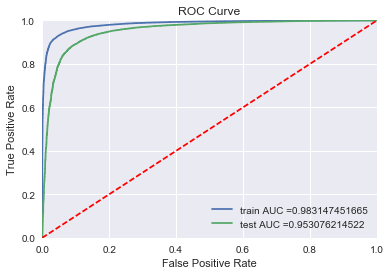

In [106]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
temp = SGDClassifier(alpha=best_c_bow,class_weight='balanced')
svmlinear=CalibratedClassifierCV(temp, cv=4)
svmlinear.fit(X_train_scale, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, svmlinear.predict_proba(X_train_scale)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svmlinear.predict_proba(X_test_scale)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.884336394373 for threshold 0.858
Train Data


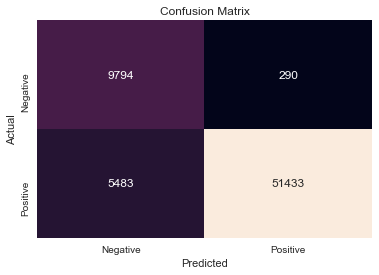

Test Data


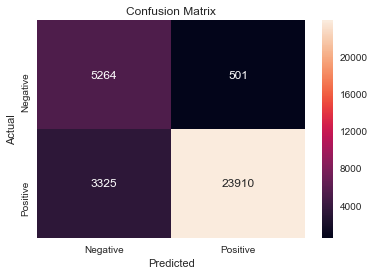

In [107]:
best_t_1 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_scale,y_train,X_test_scale,y_test,best_t_1,svmlinear)

###  Feature Importance on BOW,<font color='red'> SET 1</font>

### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [108]:
from sklearn.svm import LinearSVC
model1 = LinearSVC(C=0.1)
model1.fit(X_train_scale, y_train)
fn_bow = vectorizer.get_feature_names()
coefs_fn_bow = sorted(zip(model1.coef_[0], fn_bow))
pos = pd.DataFrame(coefs_fn_bow[:-11:-1])
print('Top 10 important features of positive class: \n' ,pos)

Top 10 important features of positive class: 
           0          1
0  0.104863      great
1  0.099762       love
2  0.090938        use
3  0.078119       like
4  0.077473       best
5  0.075453  delicious
6  0.068167       good
7  0.060753      loves
8  0.059331  excellent
9  0.058748      loved


### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [109]:
neg = pd.DataFrame(coefs_fn_bow[:10])
print('Top 10 important features of negative class: \n' ,neg)

Top 10 important features of negative class: 
           0             1
0 -0.147514       instead
1 -0.106512     recommend
2 -0.095831         tried
3 -0.082456         price
4 -0.081783      not good
5 -0.075535  disappointed
6 -0.075146         worst
7 -0.074384           not
8 -0.072824      terrible
9 -0.070842       not buy


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

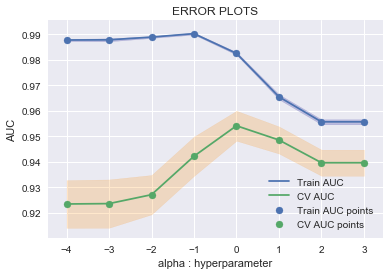

1
Wall time: 6.09 s


In [110]:
%%time
best_c_tfidf = linearsvc(X_train_tfidf,y_train)
print(best_c_tfidf)

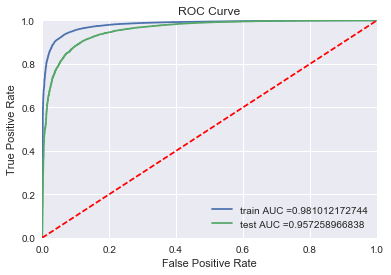

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
temp2 = SGDClassifier(alpha=best_c_tfidf,class_weight='balanced')
svmlinear2=CalibratedClassifierCV(temp2, cv=4)
svmlinear2.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, svmlinear2.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svmlinear2.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.872921685127 for threshold 0.818
Train Data


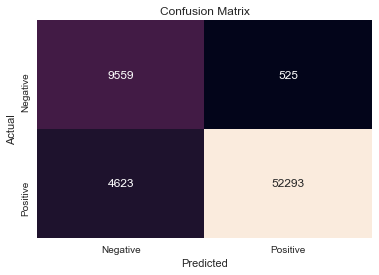

Test Data


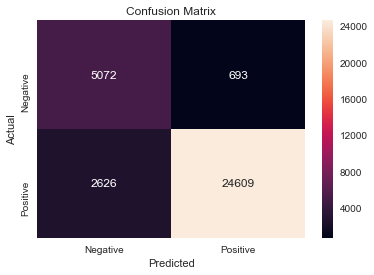

In [112]:
best_t_tfidf1 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_tfidf,y_train,X_test_tfidf,y_test,best_t_tfidf1,svmlinear2)

### Feature Importance on TFIDF,<font color='red'> SET 2</font>

### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [113]:
from sklearn.svm import LinearSVC
model2 = LinearSVC(C=0.1)
model2.fit(X_train_tfidf, y_train)
fn_tfidf = tf_idf_vect.get_feature_names()
coefs_fn_tfidf = sorted(zip(model2.coef_[0], fn_tfidf))
pos = pd.DataFrame(coefs_fn_bow[:-11:-1])
print('Top 10 important features of positive class: \n' ,pos)

Top 10 important features of positive class: 
           0          1
0  0.104863      great
1  0.099762       love
2  0.090938        use
3  0.078119       like
4  0.077473       best
5  0.075453  delicious
6  0.068167       good
7  0.060753      loves
8  0.059331  excellent
9  0.058748      loved


### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [114]:
neg = pd.DataFrame(coefs_fn_tfidf[:10])
print('Top 10 important features of negative class: \n' ,neg)

Top 10 important features of negative class: 
           0              1
0 -0.518348            not
1 -0.449265   disappointed
2 -0.448946          worst
3 -0.408512      two stars
4 -0.359629  not recommend
5 -0.323114       terrible
6 -0.314085         bitter
7 -0.290558    wanted like
8 -0.283669          awful
9 -0.277625       not good


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

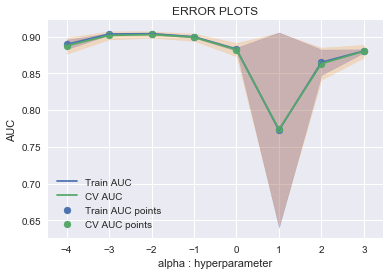

0.01
Wall time: 5.55 s


In [115]:
%%time
best_c_avgw2v = linearsvc(sent_vectors_train,y_train)
print(best_c_avgw2v)

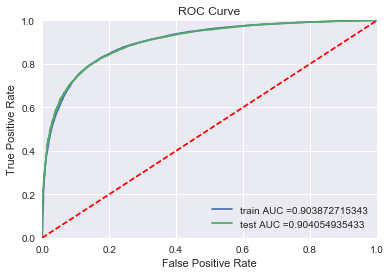

In [116]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
temp3 = SGDClassifier(alpha=best_c_avgw2v,class_weight='balanced')
svmlinear3=CalibratedClassifierCV(temp3, cv=4)
svmlinear3.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, svmlinear3.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svmlinear3.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Train Data


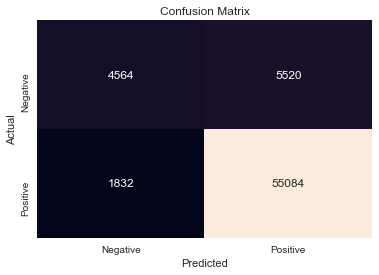

Test Data


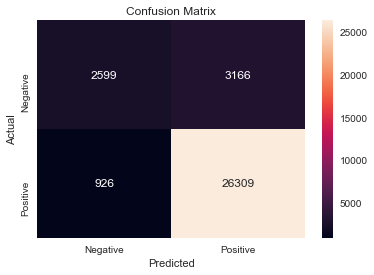

In [117]:
#best_t_avgw2v1 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(sent_vectors_train,y_train,sent_vectors_test,y_test,0.5,svmlinear3)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

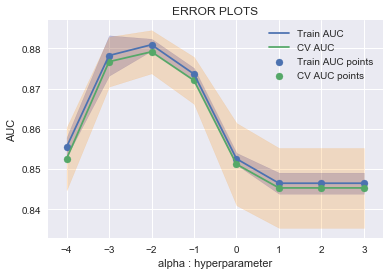

0.01
Wall time: 5.65 s


In [118]:
%%time
best_c_tfidf_avgw2v = linearsvc(tfidf_sent_vectors_train,y_train)
print(best_c_tfidf_avgw2v)

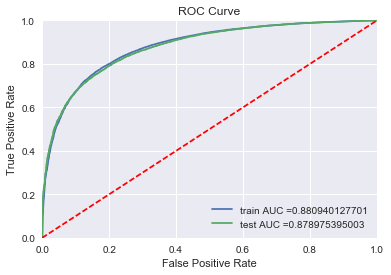

In [119]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
temp4 = SGDClassifier(alpha=best_c_tfidf_avgw2v,class_weight='balanced')
svmlinear4=CalibratedClassifierCV(temp4, cv=4)
svmlinear4.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, svmlinear4.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, svmlinear4.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Train Data


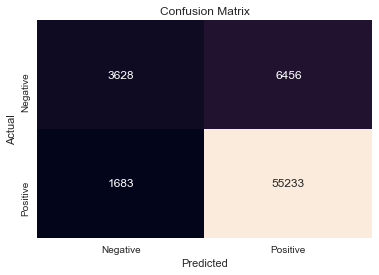

Test Data


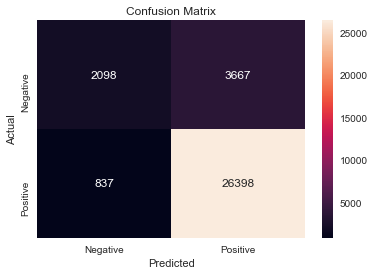

In [120]:
#best_t_tfidf_avgw2v = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(tfidf_sent_vectors_train,y_train,tfidf_sent_vectors_test,y_test,0.5,svmlinear4)

## [5.2] RBF SVM

# Function for finding the best C using gridsearch on SVC using rbf kernel

In [143]:
def rbfsvc(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    import numpy as np
    from sklearn.svm import SVC
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    parameters = {'C': [10**x for x in range(-4,4)]}
    K =[10**x for x in range(-4,4)]
    K = np.log10(K)
    
    svm = SVC(kernel='rbf', class_weight='balanced')
    clf = GridSearchCV(svm, parameters, cv=3, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']
    bestparam = clf.best_params_
    best_c = list(bestparam.values())[0]


    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return best_c

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

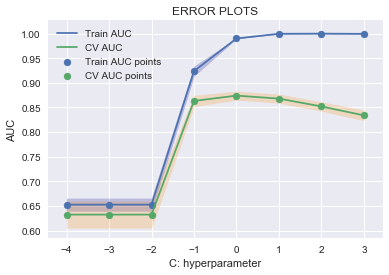

Best C:  1
Wall time: 13min 1s


In [144]:
%%time
best_c_rbf = rbfsvc(X_train_scale_rbf,y_train_1)
print('Best C: ', best_c_rbf)

# Training SVC with rbf kernel model using best hyperparameter

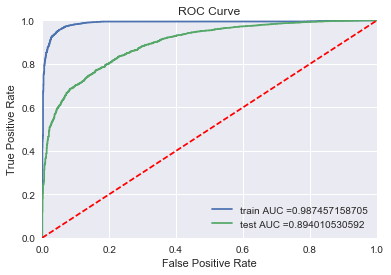

In [145]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.svm import SVC
rbfsvm = SVC(kernel='rbf',probability=True, C =best_c_rbf,class_weight='balanced')
rbfsvm.fit(X_train_scale_rbf, y_train_1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_1, rbfsvm.predict_proba(X_train_scale_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, rbfsvm.predict_proba(X_test_scale_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.907537081899 for threshold 0.909
Train Data


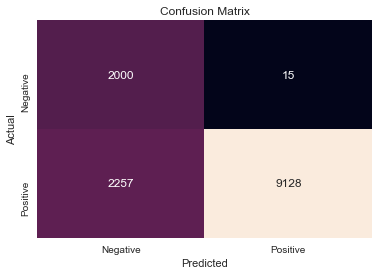

Test Data


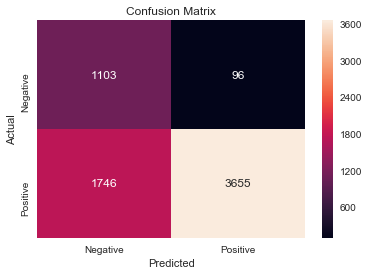

In [146]:
best_t_2 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_scale_rbf,y_train_1,X_test_scale_rbf,y_test_1,best_t_2,rbfsvm)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

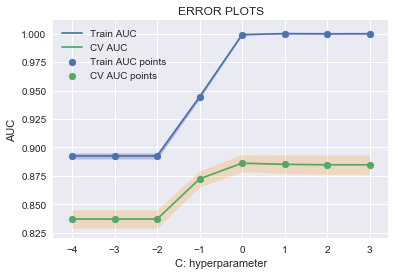

Best C:  1
Wall time: 14min


In [147]:
%%time
best_c_rbf_tfidf = rbfsvc(X_train_tfidf_rbf,y_train_1)
print('Best C: ', best_c_rbf_tfidf)

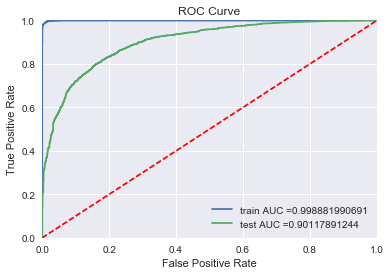

In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.svm import SVC
rbfsvm2 = SVC(kernel='rbf',probability=True, C =best_c_rbf_tfidf,class_weight='balanced')
rbfsvm2.fit(X_train_tfidf_rbf ,y_train_1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_1, rbfsvm2.predict_proba(X_train_tfidf_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, rbfsvm2.predict_proba(X_test_tfidf_rbf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.982943470742 for threshold 0.979
Train Data


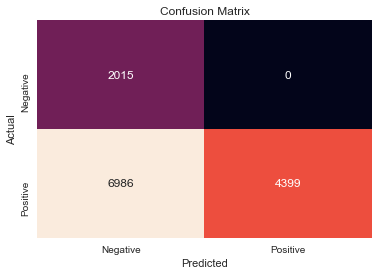

Test Data


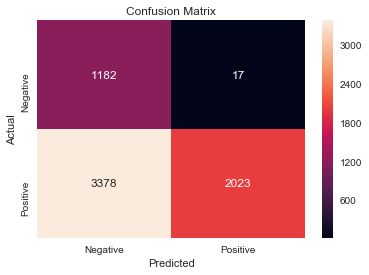

In [149]:
best_t_rbf_tfidf = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_tfidf_rbf,y_train_1,X_test_tfidf_rbf,y_test_1,best_t_rbf_tfidf,rbfsvm2)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

## vectorization for rbf kernel

In [122]:
#splitting data into X and Y
Y_1= fd_1.Score
X_1=fd_1.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train_1.shape, y_train_1.shape)
print('Test---->',X_test_1.shape, y_test_1.shape)
i=0
list_of_sentance_train=[]
for sentance in X_train_1:
    list_of_sentance_train.append(sentance.split())
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

Before Vectorization
Train---> (13400,) (13400,)
Test----> (6600,) (6600,)


#### converting train data

In [123]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.33, shuffle=False)# this is for time series split
from tqdm import tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in X_train_1:
    list_of_sentance_train.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 13400/13400 [00:49<00:00, 268.34it/s]

(13400, 50)
[ 0.02072453  0.14154292 -0.39310901  0.22387023 -0.03653781 -0.1348998
 -0.05079704  0.10032842 -0.97078162 -0.52201187  0.14414945 -0.13960948
  0.26172036  0.39922971  0.17224825  0.22015651 -0.15699791 -0.13840293
  0.46352882 -0.03542565  0.22082222 -0.23225185 -0.23503318  0.06348903
  0.10734033 -0.32790965  0.454819    0.02760918  0.41341024 -0.44634169
 -0.1393567  -0.37932037 -0.05016195 -0.21874556  0.18736259  0.02131231
  0.55866139 -0.23217264 -0.11463074  0.06951303 -0.20809365 -0.44290947
  0.29416145 -0.10795653 -0.34714784 -0.04234982 -0.08524877 -0.36691701
  0.08186327 -0.25885664]


#### converting test data

In [124]:
i=0
list_of_sentance_test=[]
for sentance in X_test_1:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 6600/6600 [00:26<00:00, 250.59it/s]

(6600, 50)
[ 0.00392644  0.03527597 -0.76721502  0.18654691 -0.11362519  0.16852501
 -0.19310786  0.16123251 -1.70165161 -0.61540254 -0.26529343 -0.16207074
  0.22774277  1.03622409  0.46277857  0.27670645 -0.21996148 -0.10740854
  1.07779423 -0.52352904 -0.03253621 -0.0789615   0.05794211  0.11615346
  0.09670632 -0.22118988  1.21935485  0.18662223  0.7304225  -1.06270888
  0.12842658 -0.43840231  0.22231235 -0.12824733  0.44163697  0.03146974
  0.51347349 -0.180628    0.50837139  0.14129816 -0.43021466 -0.37246677
  0.59043455 -0.25315898 -0.78211994 -0.20022114 -0.27759748 -0.31842185
 -0.24435267 -0.615742  ]


# Hyperparameter tuning

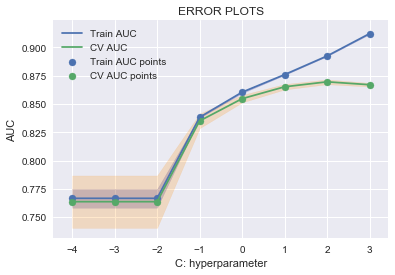

Best C:  100
Wall time: 5min 12s


In [130]:
%%time
best_c_rbf_avgw2v = rbfsvc(sent_vectors_train,y_train_1)
print('Best C: ', best_c_rbf_avgw2v)

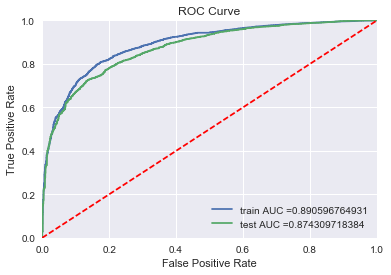

In [133]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.svm import SVC
rbfsvm3 = SVC(kernel='rbf',probability=True, C =best_c_rbf_avgw2v,class_weight='balanced')
rbfsvm3.fit(sent_vectors_train ,y_train_1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_1, rbfsvm3.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, rbfsvm3.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.667501642817 for threshold 0.742
Train Data


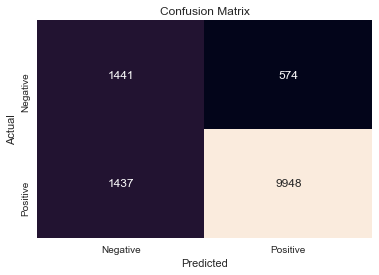

Test Data


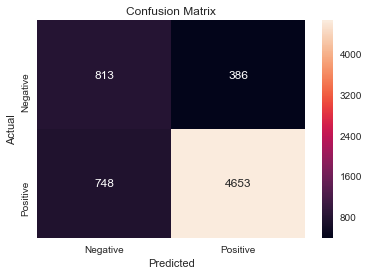

In [134]:
best_t_rbf_avgw2v = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(sent_vectors_train,y_train_1,sent_vectors_test,y_test_1,best_t_rbf_avgw2v,rbfsvm3)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

# for rbf kernel

In [135]:
#splitting data into X and Y
Y_1= fd_1.Score
X_1=fd_1.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, Y_1, test_size=0.33, shuffle=False)# this is for time series split
model2 = TfidfVectorizer()
tf_idf_train_w2v_rbf= model2.fit_transform(X_train_1)
tf_idf_test_w2v_rbf= model2.transform(X_test_1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary2 = dict(zip(model2.get_feature_names(), list(model2.idf_)))
print(tf_idf_train_w2v_rbf.shape, tf_idf_test_w2v_rbf.shape)

(13400, 22339) (6600, 22339)


#### converting train data

In [136]:
i=0
list_of_sentance_train=[]
for sentance in X_train_1:
    list_of_sentance_train.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_train = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

100%|██████████| 13400/13400 [02:57<00:00, 75.47it/s] 


In [137]:
i=0
list_of_sentance_test=[]
for sentance in X_test_1:
    list_of_sentance_test.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat_test = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

100%|██████████| 6600/6600 [01:35<00:00, 69.27it/s] 


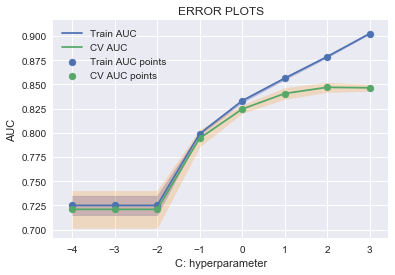

Best C:  100
Wall time: 6min 14s


In [138]:
%%time
best_c_rbf_tfidfavgw2v = rbfsvc(tfidf_sent_vectors_train,y_train_1)
print('Best C: ', best_c_rbf_tfidfavgw2v)

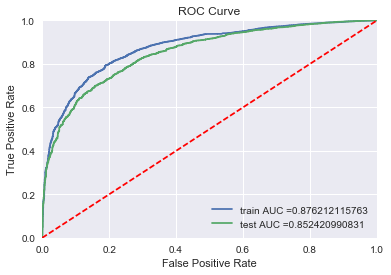

In [140]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.svm import SVC
rbfsvm4 = SVC(kernel='rbf',probability=True, C =best_c_rbf_tfidfavgw2v,class_weight='balanced')
rbfsvm4.fit(tfidf_sent_vectors_train ,y_train_1)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train_1, rbfsvm4.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_1, rbfsvm4.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.642503359193 for threshold 0.748
Train Data


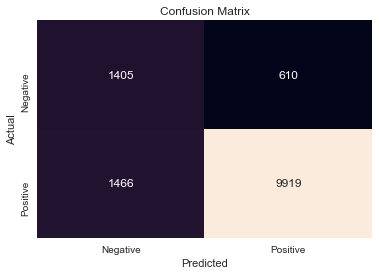

Test Data


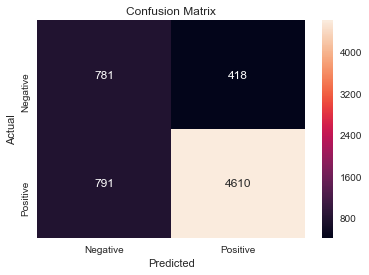

In [141]:
best_t_rbf_tfidfavgw2v = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(tfidf_sent_vectors_train,y_train_1,tfidf_sent_vectors_test,y_test_1,best_t_rbf_tfidfavgw2v,rbfsvm4)

# [6] Conclusions

In [150]:
# Creating table using PrettyTable library
from prettytable import PrettyTable
vectorizer = ['BOW','TFIDF','Avgw2v','TFIDFW2v','BOW','TFIDF','Avgw2v','TFIDFW2v' ]
AUC = [0.95,0.95,0.90,0.87,0.89,0.90,0.87,0.85]
Model = ['LinearSVM (SGD)','LinearSVM (SGD)','LinearSVM (SGD)','LinearSVM (SGD)', 'RBF Kernel (SVC)','RBF Kernel (SVC)','RBF Kernel (SVC)','RBF Kernel (SVC)',]
hyperparameter= [10,1,0.01,0.01,1,1,100,100]
sno = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()
# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("     Vectorizer            ",vectorizer)
ptable.add_column("      Model                         "   ,      Model)
ptable.add_column("  Best C (alpha for SGD)     ",hyperparameter)
ptable.add_column("  Test AUC              ",AUC)
# Printing the Table
print(ptable)

+-------+-----------------------------+--------------------------------------+-------------------------------+--------------------------+
| S.NO. |      Vectorizer             |       Model                          |   Best C (alpha for SGD)      |   Test AUC               |
+-------+-----------------------------+--------------------------------------+-------------------------------+--------------------------+
|   1   |             BOW             |           LinearSVM (SGD)            |               10              |           0.95           |
|   2   |            TFIDF            |           LinearSVM (SGD)            |               1               |           0.95           |
|   3   |            Avgw2v           |           LinearSVM (SGD)            |              0.01             |           0.9            |
|   4   |           TFIDFW2v          |           LinearSVM (SGD)            |              0.01             |           0.87           |
|   5   |             BOW         

In [152]:
!jupyter nbconvert --to html AFFRSVM.ipynb

[NbConvertApp] Converting notebook AFFRSVM.ipynb to html
[NbConvertApp] Writing 1292744 bytes to AFFRSVM.html
